LAB 4:  ANALZING NETWORK DATA LOG

You are provided with the data file, in .csv format, in the working directory.  Write the program to extract the following informations. 

Exercise 4A: TOP TALKERS AND LISTENERS

One of the most commonly used function in analyzing data log is finding out the IP address of the hosts that send out large amount of packet and hosts that receive large number of packets, usually know as TOP TALKERS and LISTENERS.  Based on the IP address we can obtained the organization who owns the IP address. 

In [1]:
# in order to check the organization
!pip install ipwhois


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from ipwhois import IPWhois
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
column_names = ['Type', 'sflow_agent_address', 'inputPort', 'outputPort',
          'src_MAC', 'dst_MAC', 'ethernet_type', 'in_vlan', 'out_vlan',
          'src_IP', 'dst_IP', 'IP_protocol', 'ip_tos', 'ip_ttl',
          'udp_src_port', 'udp_dst_port', 'tcp_flags',
          'packet_size', 'IP_size', 'sampling_rate', 'unknown']
df = pd.read_csv("Data_3.csv", header=None, names=column_names)
df.drop('unknown', axis=1, inplace=True)

In [4]:
# extract organization name
def org(ip):
    obj = IPWhois(ip)
    organization = obj.lookup_rdap()['network']['name']
    return organization

# top 5 talkers
top_talkers = df.groupby('src_IP').size().reset_index(name='# of packets')
top_talkers = top_talkers.sort_values(by='# of packets', ascending=False).head(5).reset_index(drop=True)
top_talkers['Organization'] = top_talkers['src_IP'].apply(org)
top_talkers

,src_IP,# of packets,Organization
0,193.62.192.8,3041,EUR-BIO-INST
1,155.69.160.32,2975,NTUNET1
2,130.14.250.11,2604,NLM-ETHER
3,14.139.196.58,2452,NKN-IIT-GUW
4,140.112.8.139,2056,T-NTU.EDU.TW-NET


In [5]:
# top 5 listeners
top_listeners = df.groupby('dst_IP').size().reset_index(name='# of packets')
top_listeners = top_listeners.sort_values(by='# of packets', ascending=False).head(5).reset_index(drop=True)
top_listeners['Organization'] = top_listeners['dst_IP'].apply(org)
top_listeners

,dst_IP,# of packets,Organization
0,103.37.198.100,3841,A-STAR-AS-AP
1,137.132.228.15,3715,NUSNET
2,202.21.159.244,2446,RPNET
3,192.101.107.153,2368,PNNL
4,103.21.126.2,2056,IITB-IN


Exercise 4B: TRANSPORT PROTOCOL 

Using the IP protocol type attribute, determine the percentage of TCP and UDP protocol

In [6]:
protocol = df.groupby('IP_protocol').size().reset_index(name='# of packets')
total_num = protocol['# of packets'].sum()
protocol = protocol[(protocol['IP_protocol'] == 6) | (protocol['IP_protocol'] == 17)]
protocol['percentage'] = [protocol.loc[protocol['IP_protocol'] == 6, '# of packets'].values[0] / total_num, protocol.loc[protocol['IP_protocol'] == 17, '# of packets'].values[0] / total_num]
protocol

,IP_protocol,# of packets,percentage
2,6,56064,0.808188
3,17,9462,0.136399


EXERCISE 4C: APPLICATIONS PROTOCOL

Using the Destination IP port number determine the most frequently used application protocol.
(For finding the service given the port number https://www.adminsub.net/tcp-udp-port-finder/ )

In [7]:
port = df.groupby('udp_dst_port').size().reset_index(name='# of packets').sort_values(by='# of packets', ascending=False).head(5).reset_index(drop=True)
port['Service'] = ['HTTPS', 'HTTP', 'Dynamic and/or Private Ports', 'Unassigned', 'Dynamic and/or Private Ports']
port

,udp_dst_port,# of packets,Service
0,443,13423,HTTPS
1,80,2647,HTTP
2,52866,2068,Dynamic and/or Private Ports
3,45512,1356,Unassigned
4,56152,1341,Dynamic and/or Private Ports


EXERCISE 4D: TRAFFIC 

The traffic intensity is an important parameter that a network engineer needs to monitor closely to determine if there is congestion. You would use the IP packet size to calculate the estimated total traffic over the monitored period of 15 seconds. (Assume the sampling rate is 1 in 2048)  

In [8]:
traffic = df['IP_size'].sum()
traffic = traffic / (2 ** 20) * 2048
print(f'Total traffic: {traffic}MB')

Total traffic: 126519.18359375MB


EXERCISE 4E: ADDITIONAL ANALYSIS 

Please append ONE page to provide additional analysis of the data and the insight it provides.
Examples include:

Top 5 communication pairs; 

Visualization of communications between different IP hosts;

etc.

In [9]:
# top 5 communication pairs
top_pairs = df.groupby(['src_IP', 'dst_IP']).size().reset_index(name='# of packets').sort_values(by='# of packets', ascending=False).head(5).reset_index(drop=True)
top_pairs['src_org'] = top_pairs['src_IP'].apply(org)
top_pairs['dst_org'] = top_pairs['dst_IP'].apply(org)
top_pairs

,src_IP,dst_IP,# of packets,src_org,dst_org
0,193.62.192.8,137.132.228.15,3041,EUR-BIO-INST,NUSNET
1,130.14.250.11,103.37.198.100,2599,NLM-ETHER,A-STAR-AS-AP
2,14.139.196.58,192.101.107.153,2368,NKN-IIT-GUW,PNNL
3,140.112.8.139,103.21.126.2,2056,T-NTU.EDU.TW-NET,IITB-IN
4,137.132.228.15,193.62.192.8,1910,NUSNET,EUR-BIO-INST


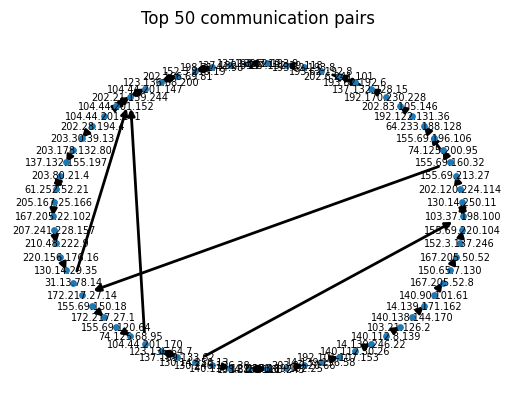

In [11]:
df = df.groupby(['src_IP', 'dst_IP']).size().reset_index(name='# of packets').sort_values(by='# of packets', ascending=False).head(50).reset_index(drop=True)
G = nx.from_pandas_edgelist(df, 'src_IP', 'dst_IP',  create_using=nx.DiGraph())
num_nodes = len(G.nodes())
angular_separation = 2 * np.pi / num_nodes
random_angles = np.arange(0, 2 * np.pi, angular_separation)
pos = {node: (np.cos(angle), np.sin(angle)) for node, angle in zip(G.nodes(), random_angles)}
nx.draw_networkx_nodes(G, pos, node_size=15)
nx.draw_networkx_edges(G, pos, width=2, arrows=True)
nx.draw_networkx_labels(G, pos, font_size=7)
plt.title('Top 50 communication pairs')
plt.axis('off')
plt.show()